In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

%store -r DISCO_ROOT_FOLDER
if "DISCO_ROOT_FOLDER" in globals():
    os.chdir(DISCO_ROOT_FOLDER)
    sys.path.append(DISCO_ROOT_FOLDER)

['0.0: 1000', '1.0: 1000', '2.0: 1000', '-1.0: 300']


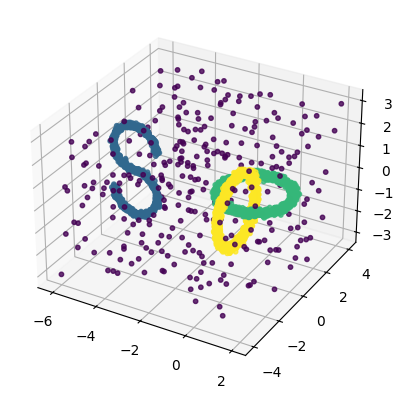

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from clustpy.utils import plot_3d_data
from sklearn.datasets import make_s_curve, make_circles

def create_multiple_shapes(clusters_sizes=1000, seed=1, spread=0.2):
    random_state = np.random.RandomState(seed)

    # Add S-curve
    X_curve, _ = make_s_curve(clusters_sizes, random_state=random_state, noise=spread / 4)
    # Change width of non-S dimension
    X_curve[:, 1] = (
        (X_curve[:, 1] - np.min(X_curve[:, 1]))
        / (np.max(X_curve[:, 1]) - np.min(X_curve[:, 1]))
        * spread
        + spread / 2
        + 1.5
    )
    X_curve[:, 1] += -1.7
    X_curve[:, 0] -= 5

    # Add two circles
    X_circle1, L_circle1 = make_circles(
        2 * clusters_sizes, noise=spread / 4, random_state=random_state
    )
    X_circle1 = X_circle1[L_circle1 == 0]
    # Create second circle that can later be rotated
    X_circle2 = X_circle1.copy()
    # Add third dimension to first circle
    X_circle1 = np.c_[
        X_circle1, random_state.random(clusters_sizes).reshape(-1, 1) * spread - spread / 2
    ]
    # Add third dimension (at first position) to second circle -> rotated version of first circle
    X_circle2 = np.c_[
        random_state.random(clusters_sizes).reshape(-1, 1) * spread - spread / 2, X_circle2
    ]
    # Move second circle to center of first circle
    X_circle2[:, 1] -= 1
    X_circles = np.r_[X_circle1, X_circle2]
    # Move circles to correct position next to the S-curve
    # X_circles[:, 1] += 1
    X_circles[:, 1] += 0.5
    X_circles *= 1.5

    # Add blob
    # X_blob = random_state.multivariate_normal(mean=[0.5, 0, 0], cov=[[spread/4, 0, 0], [0, spread/4, 0], [0, 0, spread/4]],
    #                                           size=clusters_sizes)

    # Combine data arrays
    X = np.r_[X_curve, X_circles]  # , X_blob]

    # Create labels array
    l = np.zeros(3 * clusters_sizes)
    for i in range(1, 3):
        l[i * clusters_sizes : (i + 1) * clusters_sizes] = i

    return X, l

from src.utils.data import add_noise

X, l = create_multiple_shapes()

np.random.seed(10)
X = np.r_[X, [[2,4,3],[-6,-4,-3]]]
l = np.r_[l, [-1, -1]]
X, l = add_noise(X, l, 298, 1, 0.5)

fig = plot_3d_data(X, l, show_legend=False, show_plot=False)
axes = fig.get_axes()
for ax in axes:
    ax.set_aspect("equal", adjustable="datalim")

print([f"{c}: {len(l[l==c])}" for c in set(l)])

plt.show()

In [3]:
import numpy as np
from sklearn.datasets import make_moons

def convert_to_noise(X, l, n_noise, seed=0):
    np.random.seed(seed)
    convert_to_noise_idx = np.random.choice(len(l[l==1]), size=n_noise, replace=False)
    l_ = l.copy()
    l_[convert_to_noise_idx] = -1
    return X, l_

np.random.seed(0)
random_seeds = np.random.choice(1_000_000, replace=False, size=10)
n_noise_list = list(range(0, 1001, 100))
convert_noise_dataset = [
    [convert_to_noise(X, l, n_noise, seed=seed) for seed in random_seeds]
    for n_noise in n_noise_list
]

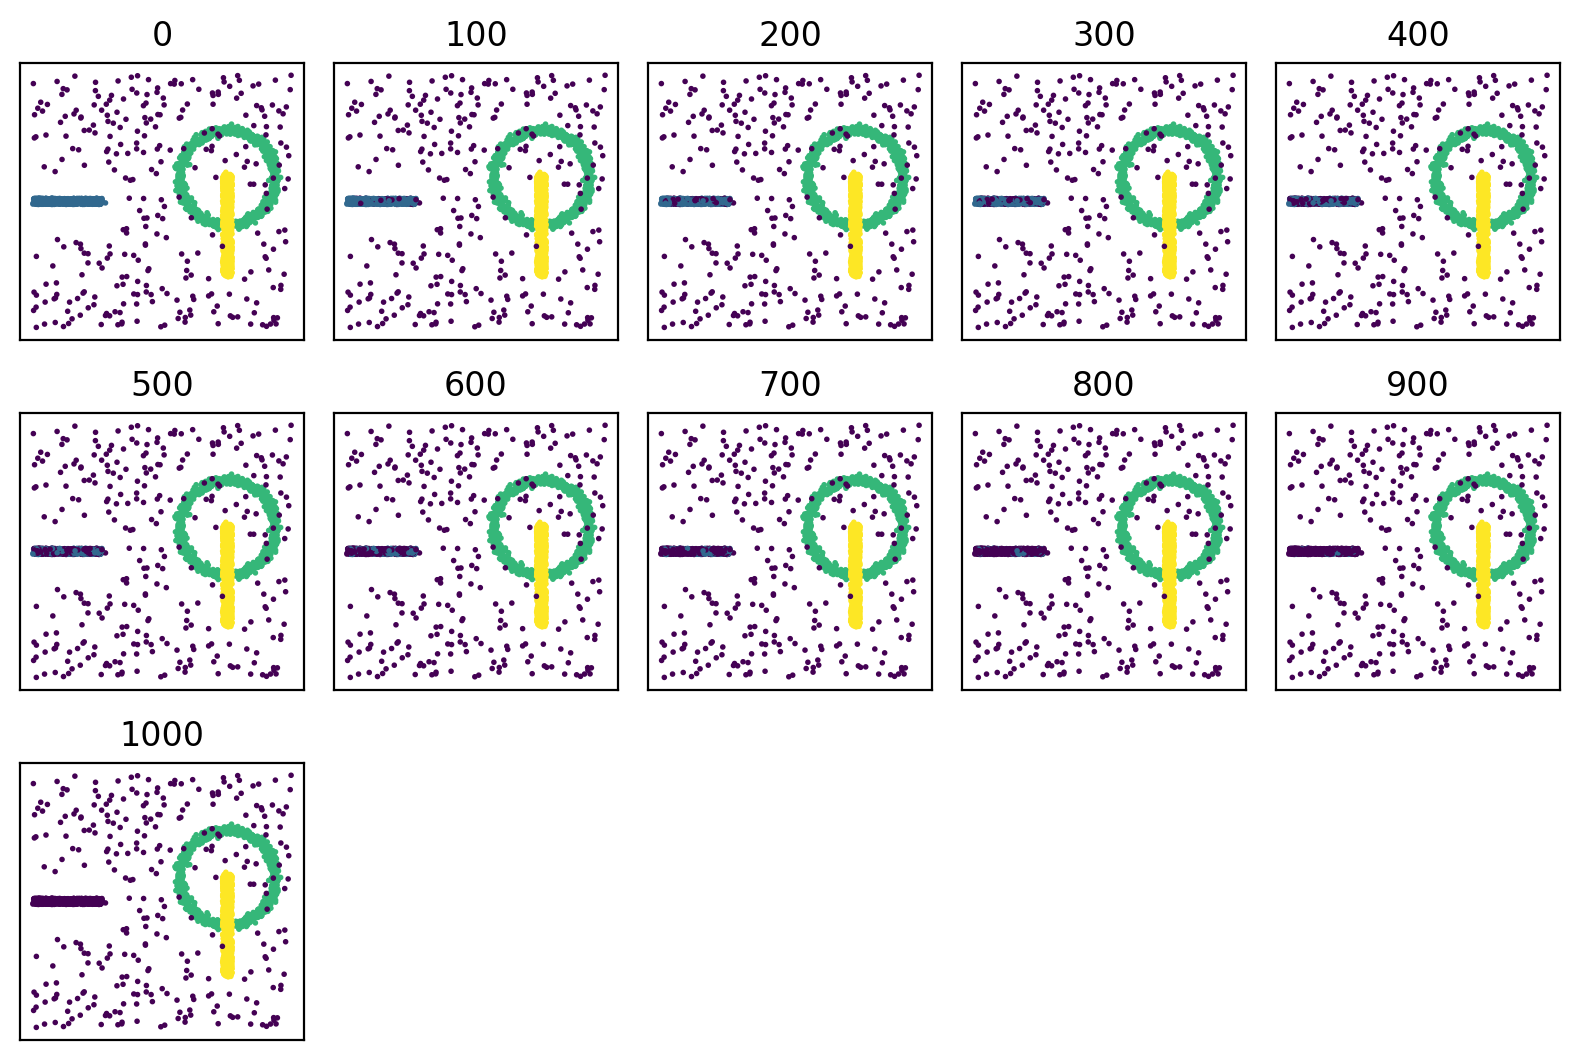

In [4]:
import matplotlib.pyplot as plt
from src.utils.plots import plot_datasets

plot_datasets(convert_noise_dataset, n_noise_list, n_cols=5, figsize=1.6)
plt.savefig("imgs/S+Rings_Noise.png")

In [5]:
from src.Evaluation.disco import disco_score as DISCO, p_noise as p_noise

# Competitors
from src.Evaluation.dbcv import validity_index as DBCV
from src.Evaluation.dcsi import dcsi_score as DCSI
from src.Evaluation.s_dbw import sdbw_score as S_DBW
from src.Evaluation.cdbw import cdbw_score as CDBW
from src.Evaluation.cvdd_new import cvdd_score as CVDD
from src.Evaluation.cvnn import cvnn_score as CVNN
from src.Evaluation.lccv import lccv_score as LCCV
from src.Evaluation.viasckde import viasckde_score as VIASCKDE

# Gauss
from sklearn.metrics import silhouette_score as SILHOUETTE

METRICS_as_is = {
    "DISCO": lambda X, l: DISCO(X, l),
    ### Competitors
    "DBCV": lambda X, l: DBCV(X, l),
    "DCSI": lambda X, l: DCSI(X, l),
    "LCCV": lambda X, l: LCCV(X, l),
    "VIASCKDE": lambda X, l: VIASCKDE(X, l),
    "CVDD": lambda X, l: CVDD(X, l),
    "CDBW": lambda X, l: CDBW(X, l),
    "CVNN": lambda X, l: CVNN(X, l),
    ### Gauss
    "SILHOUETTE": lambda X, l: SILHOUETTE(X, l),
    "S_DBW": lambda X, l: S_DBW(X, l),
}


METRICS_filtered = {
    "DISCO": lambda X, l: DISCO(X, l),
    "DISCO_": lambda X, l: DISCO(X[l != -1], l[l != -1]),
    ### Competitors
    "DBCV": lambda X, l: DBCV(X[l != -1], l[l != -1]),
    "DCSI": lambda X, l: DCSI(X[l != -1], l[l != -1]),
    "LCCV": lambda X, l: LCCV(X[l != -1], l[l != -1]),
    "VIASCKDE": lambda X, l: VIASCKDE(X[l != -1], l[l != -1]),
    "CVDD": lambda X, l: CVDD(X[l != -1], l[l != -1]),
    "CDBW": lambda X, l: CDBW(X[l != -1], l[l != -1]),
    "CVNN": lambda X, l: CVNN(X[l != -1], l[l != -1]),
    ### Gauss
    "SILHOUETTE": lambda X, l: SILHOUETTE(X[l != -1], l[l != -1]),
    "S_DBW": lambda X, l: S_DBW(X[l != -1], l[l != -1]),
}


def noise_as_cluster(l):
    l_ = l.copy()
    l_[l_ == -1] = len(set(l))
    return l_

METRICS_noise_as_cluster = {
    "DISCO": lambda X, l: DISCO(X, l),
    "DISCO_": lambda X, l: DISCO(X, noise_as_cluster(l)),
    ### Competitors
    "DBCV": lambda X, l: DBCV(X, noise_as_cluster(l)),
    "DCSI": lambda X, l: DCSI(X, noise_as_cluster(l)),
    "LCCV": lambda X, l: LCCV(X, noise_as_cluster(l)),
    "VIASCKDE": lambda X, l: VIASCKDE(X, noise_as_cluster(l)),
    "CVDD": lambda X, l: CVDD(X, noise_as_cluster(l)),
    "CDBW": lambda X, l: CDBW(X, noise_as_cluster(l)),
    "CVNN": lambda X, l: CVNN(X, noise_as_cluster(l)),
    ### Gauss
    "SILHOUETTE": lambda X, l: SILHOUETTE(X, noise_as_cluster(l)),
    "S_DBW": lambda X, l: S_DBW(X, noise_as_cluster(l)),
}


def noise_as_its_own_cluster(l):
    l_ = l.copy()
    l_[l_ == -1] = np.arange(len(set(l)), len(l[l == -1]) + len(set(l)))
    return l_

METRICS_every_noise_is_its_own_cluster = {
    "DISCO": lambda X, l: DISCO(X, l),
    "DISCO_": lambda X, l: DISCO(X, noise_as_its_own_cluster(l)),
    ### Competitors
    "DBCV": lambda X, l: DBCV(X, noise_as_its_own_cluster(l)),
    "DCSI": lambda X, l: DCSI(X, noise_as_its_own_cluster(l)),
    "LCCV": lambda X, l: LCCV(X, noise_as_its_own_cluster(l)),
    "VIASCKDE": lambda X, l: VIASCKDE(X, noise_as_its_own_cluster(l)),
    "CVDD": lambda X, l: CVDD(X, noise_as_its_own_cluster(l)),
    "CDBW": lambda X, l: CDBW(X, noise_as_its_own_cluster(l)),
    "CVNN": lambda X, l: CVNN(X, noise_as_its_own_cluster(l)),
    ### Gauss
    "SILHOUETTE": lambda X, l: SILHOUETTE(X, noise_as_its_own_cluster(l)),
    "S_DBW": lambda X, l: S_DBW(X, noise_as_its_own_cluster(l)),
}

In [6]:
from src.utils.experiments import cache, calc_eval_measures_for_multiple_datasets
from src.utils.metrics import create_and_rescale_df, SELECTED_METRICS


eval_results = cache(
    "S+Rings_Noise_as_is",
    calc_eval_measures_for_multiple_datasets,
    [convert_noise_dataset, n_noise_list],
    {"metrics": METRICS_as_is},
    recalc=False,
)

df = create_and_rescale_df(eval_results)

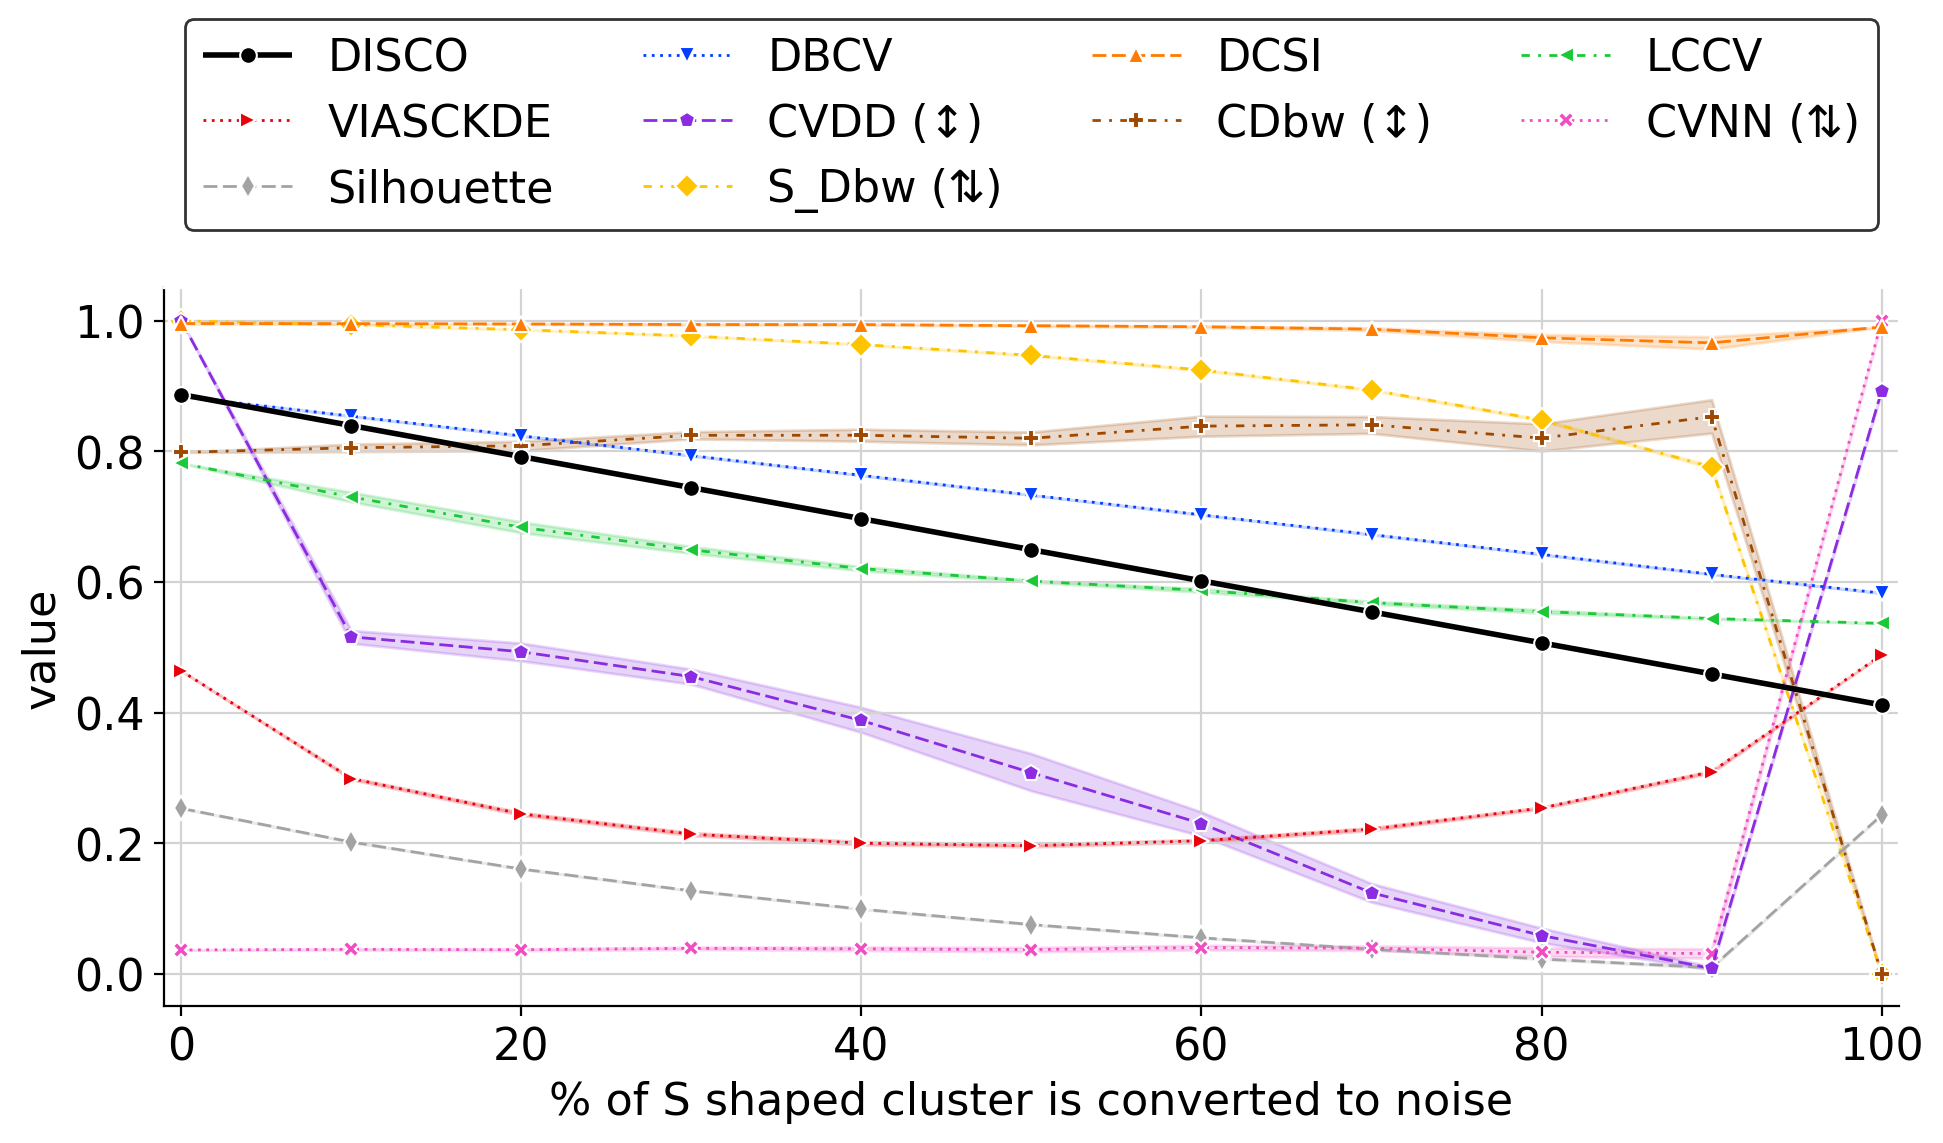

In [7]:
from src.utils.plots import plot_lineplot

eps = 10
x_range = n_noise_list[0] - eps, n_noise_list[-1] + eps
x_range = np.array(x_range) / 10
df["dataset"] = df["dataset"] / 10

plot_lineplot(df, "dataset", "value", "measure", x_label = "% of S shaped cluster is converted to noise", x_range=x_range, y_range=(None, None))
plt.savefig("imgs/S+Rings_Noise_as_is.png", bbox_inches="tight", pad_inches=0)

In [8]:
from src.utils.experiments import cache, calc_eval_measures_for_multiple_datasets
from src.utils.metrics import create_and_rescale_df


eval_results = cache(
    "S+Rings_Noise_filtered",
    calc_eval_measures_for_multiple_datasets,
    [convert_noise_dataset, n_noise_list],
    {"metrics": METRICS_filtered},
    recalc=False,
)

df = create_and_rescale_df(eval_results, SELECTED_METRICS + ["DISCO_"])

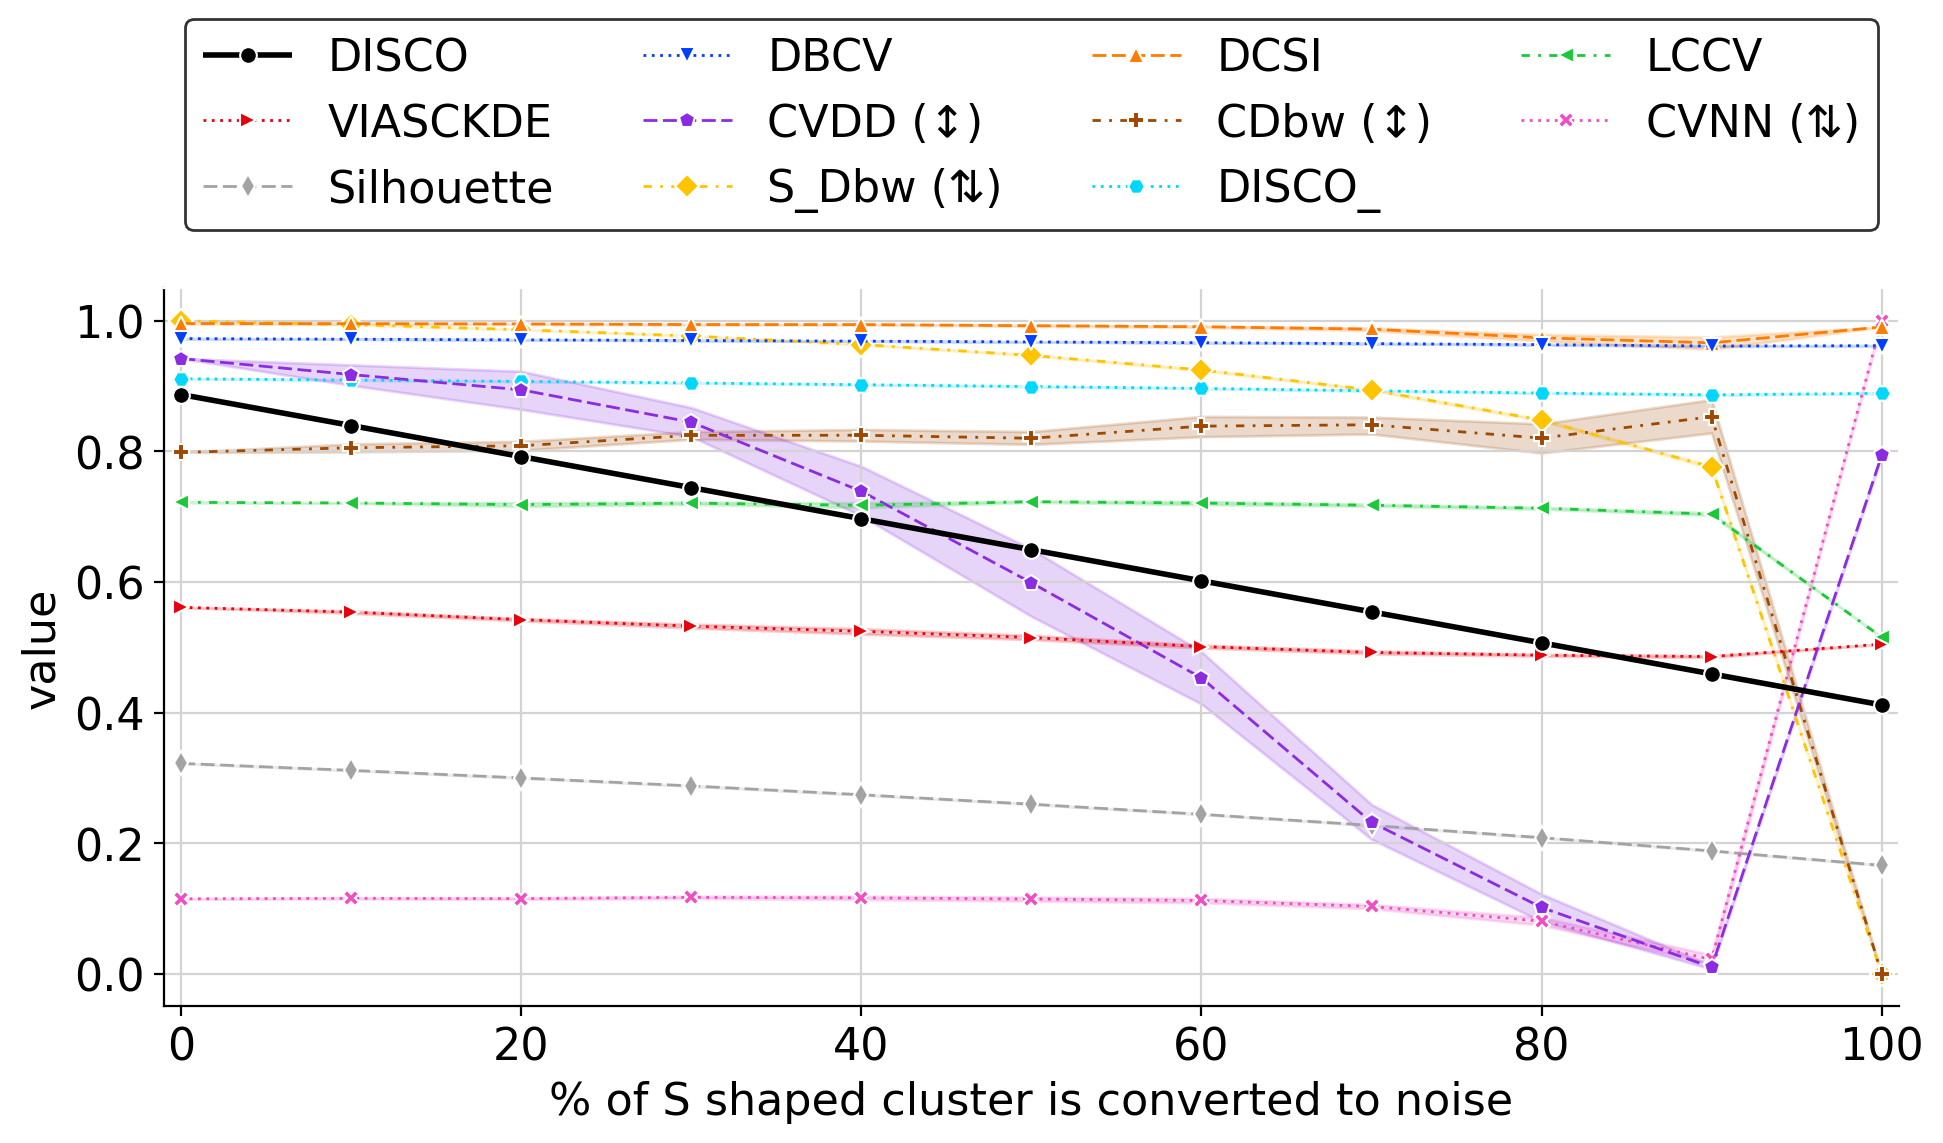

In [9]:
from src.utils.plots import plot_lineplot

eps = 10
x_range = n_noise_list[0] - eps, n_noise_list[-1] + eps
x_range = np.array(x_range) / 10
df["dataset"] = df["dataset"] / 10

plot_lineplot(df, "dataset", "value", "measure", x_label = "% of S shaped cluster is converted to noise", x_range=x_range, y_range=(None, None), order=SELECTED_METRICS + ["DISCO_"])
plt.savefig("imgs/S+Rings_Noise_filtered.png", bbox_inches="tight", pad_inches=0)

In [10]:
from src.utils.experiments import cache, calc_eval_measures_for_multiple_datasets
from src.utils.metrics import create_and_rescale_df


eval_results = cache(
    "S+Rings_Noise_as_cluster",
    calc_eval_measures_for_multiple_datasets,
    [convert_noise_dataset, n_noise_list],
    {"metrics": METRICS_noise_as_cluster},
    recalc=False,
)

df = create_and_rescale_df(eval_results, SELECTED_METRICS + ["DISCO_"])

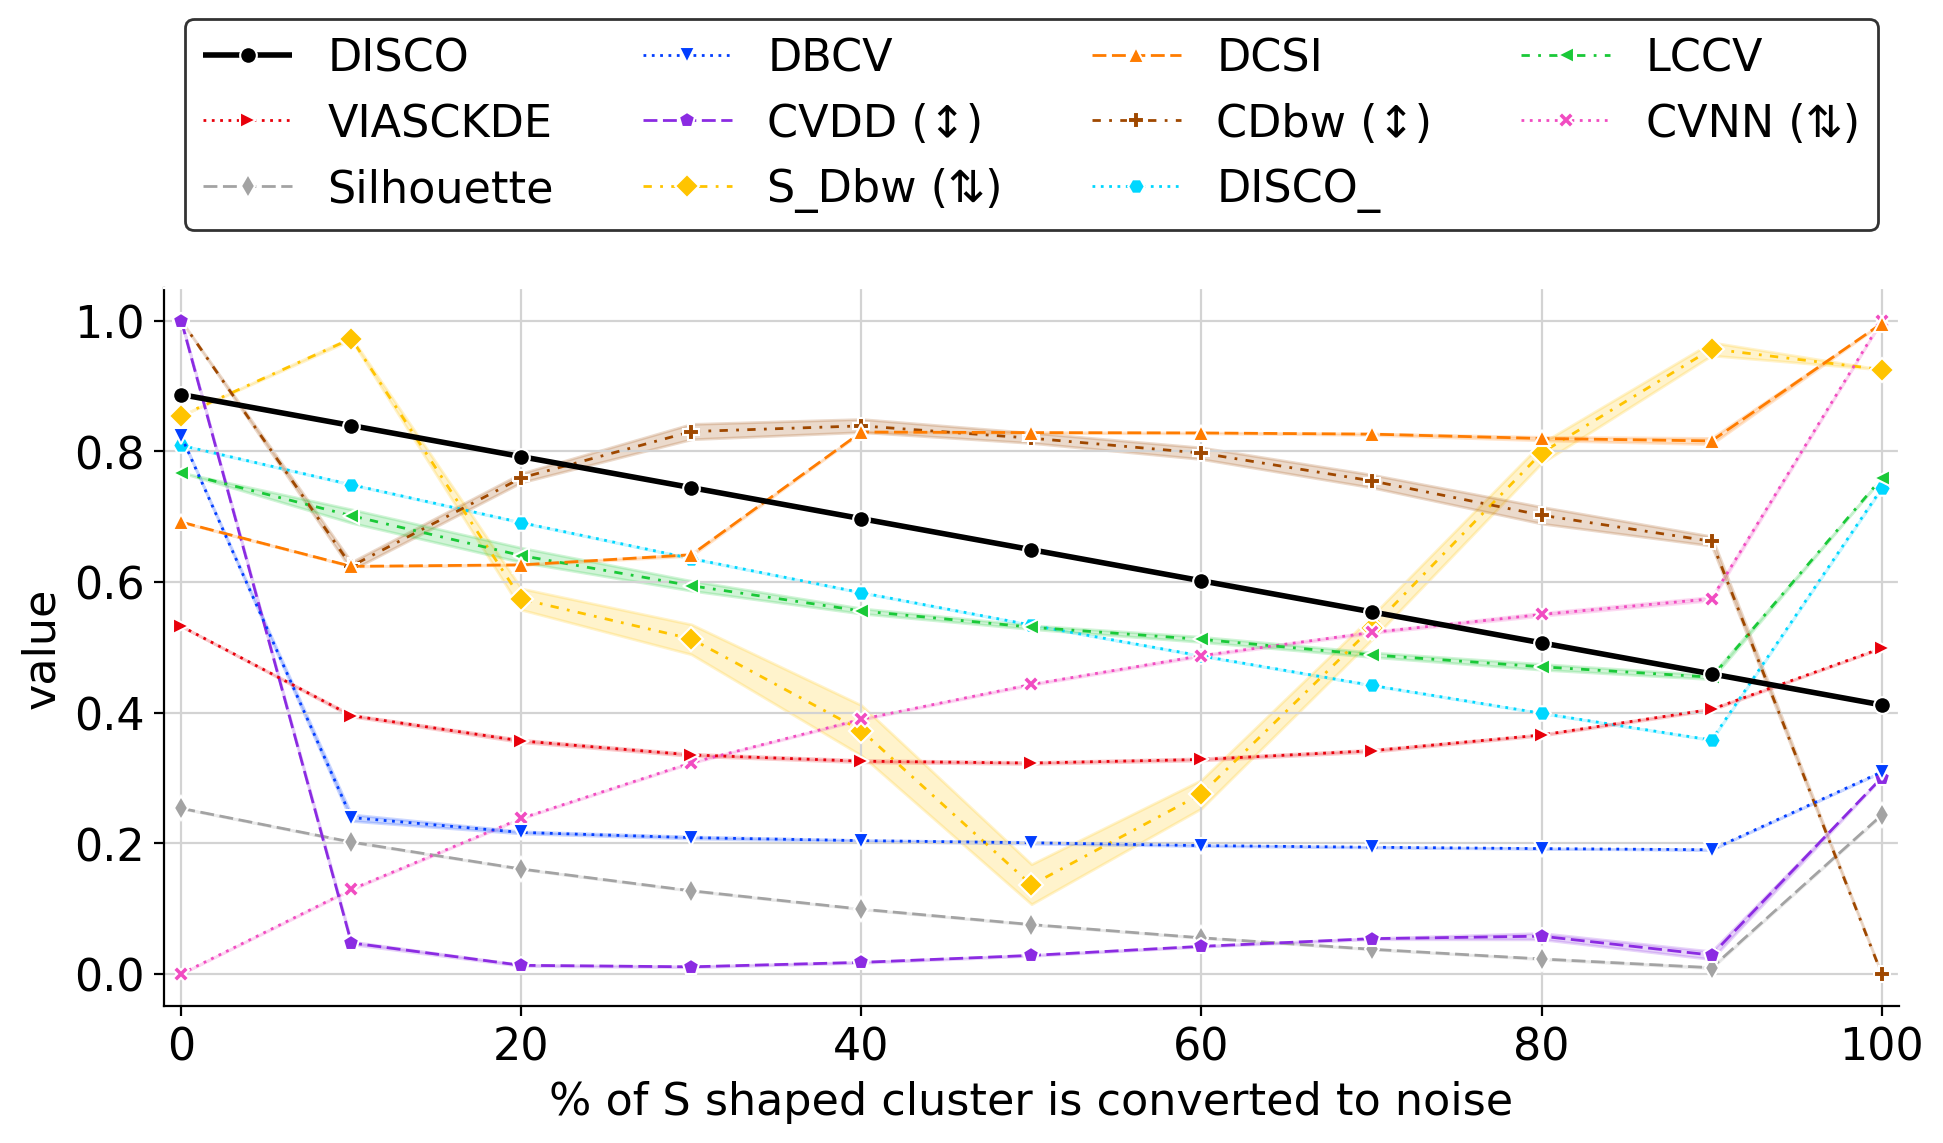

In [11]:
from src.utils.plots import plot_lineplot

eps = 10
x_range = n_noise_list[0] - eps, n_noise_list[-1] + eps
x_range = np.array(x_range) / 10
df["dataset"] = df["dataset"] / 10

plot_lineplot(df, "dataset", "value", "measure", x_label = "% of S shaped cluster is converted to noise", x_range=x_range, y_range=(None, None), order=SELECTED_METRICS + ["DISCO_"])
plt.savefig("imgs/S+Rings_Noise_as_cluster.png", bbox_inches="tight", pad_inches=0)

In [16]:
from src.utils.experiments import cache, calc_eval_measures_for_multiple_datasets
from src.utils.metrics import create_and_rescale_df


eval_results = cache(
    "S+Rings_Noise_as_is_its_own_cluster",
    calc_eval_measures_for_multiple_datasets,
    [convert_noise_dataset, n_noise_list],
    {"metrics": METRICS_every_noise_is_its_own_cluster},
    recalc=True,
)

df = create_and_rescale_df(eval_results, SELECTED_METRICS + ["DISCO_"])

/export/share/pascalw777dm/DISCO/src/Evaluation/dbcv.py:46: RuntimeWarning: invalid value encountered in divide
  result /= distance_matrix.shape[0] - 1
Traceback (most recent call last):
  File "/export/share/pascalw777dm/DISCO/src/utils/experiments.py", line 61, in exec_func
    value = fn(*data, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2547909/957776831.py", line 80, in <lambda>
    "DBCV": lambda X, l: DBCV(X, noise_as_its_own_cluster(l)),
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/export/share/pascalw777dm/DISCO/src/Evaluation/dbcv.py", line 416, in validity_index
    density_sparseness[cluster_id] = mst_edges[cluster_id].T[2].max()
                                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/export/share/pascalw777dm/miniconda3/envs/stuff/lib/python3.12/site-packages/numpy/core/_methods.py", line 41, in _amax
    return umr_maximum(a, axis, None, out, keepdims, initial, where)
           ^^^^^^^^^

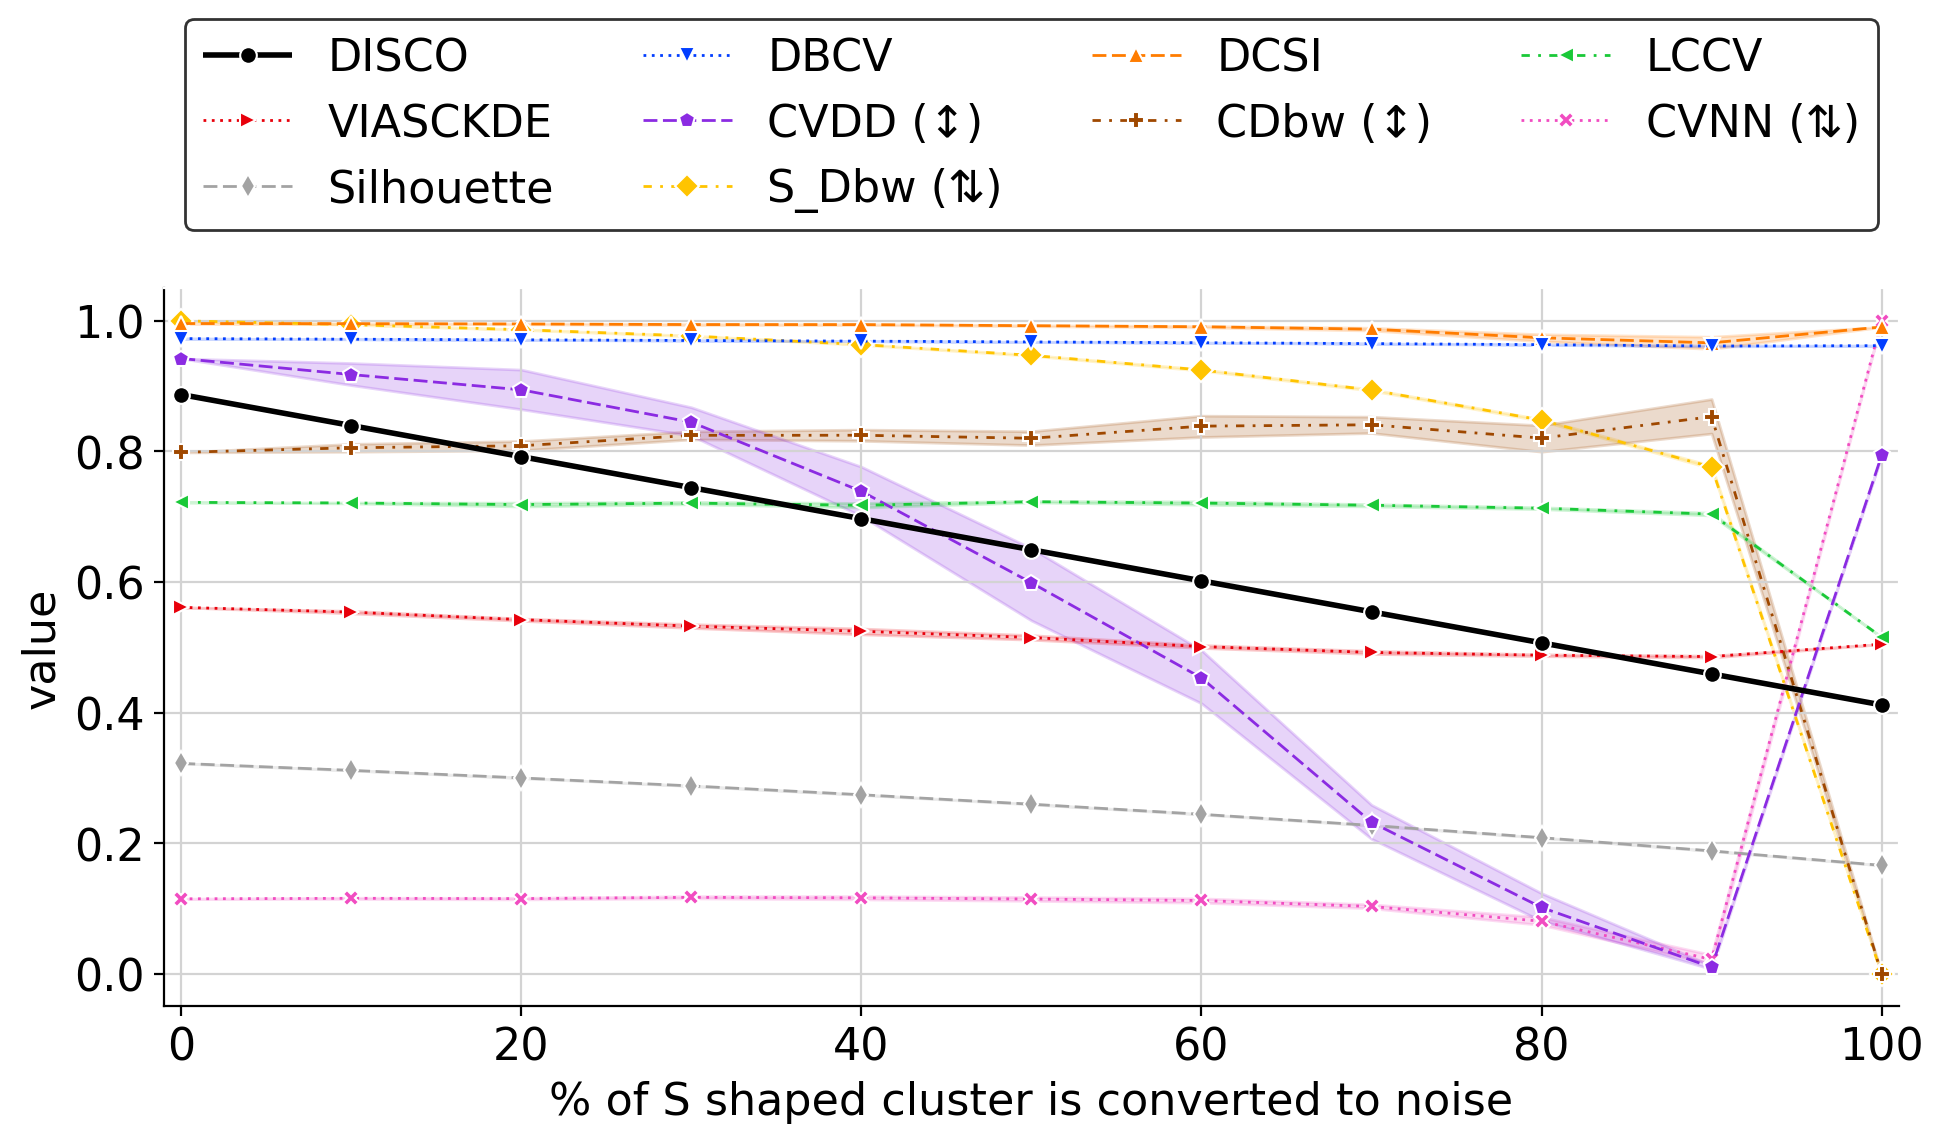

In [52]:
from src.utils.plots import plot_lineplot

eps = 10
x_range = n_noise_list[0] - eps, n_noise_list[-1] + eps
x_range = np.array(x_range) / 10
df["dataset"] = df["dataset"] / 10

plot_lineplot(df, "dataset", "value", "measure", x_label = "% of S shaped cluster is converted to noise", x_range=x_range, y_range=(None, None), order=SELECTED_METRICS + ["DISCO_"])
plt.savefig("imgs/S+Rings_Noise_as_is_its_own_cluster.png", bbox_inches="tight", pad_inches=0)

In [36]:
from src.utils.experiments import cache, calc_eval_measures
from src.utils.plots import plot_barplot
from src.utils.metrics import create_and_rescale_df

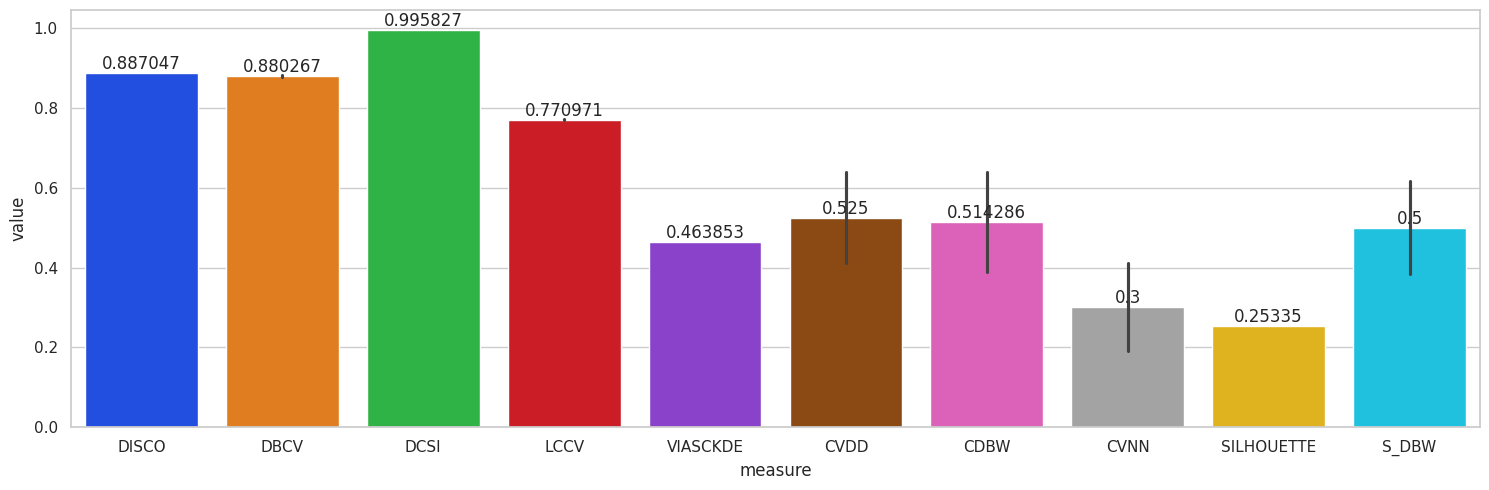

In [37]:
eval_results = cache("S+Rings", calc_eval_measures, [X, l], recalc=False)
df = create_and_rescale_df(eval_results)
plot_barplot(df, "measure", "value", "measure")
plt.show()

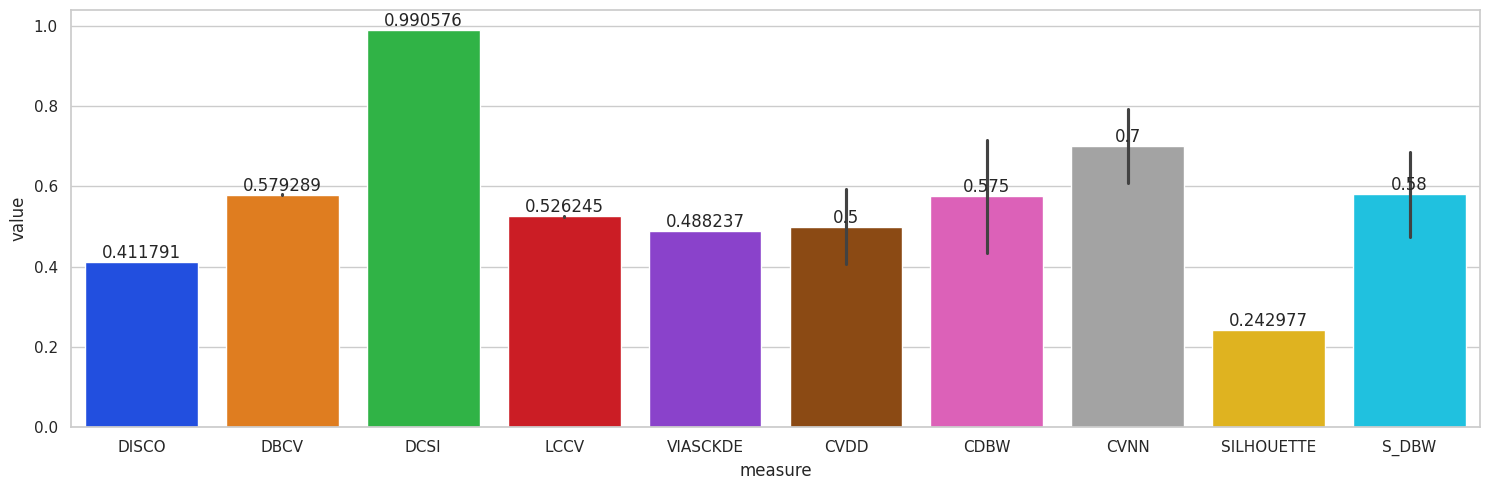

In [38]:
l_ = l.copy()
l_[l_ != -1] = l_[l_ != -1] - 1

eval_results = cache("S+Rings_S_noise", calc_eval_measures, [X, l_], recalc=False)
df = create_and_rescale_df(eval_results)
plot_barplot(df, "measure", "value", "measure")
plt.show()

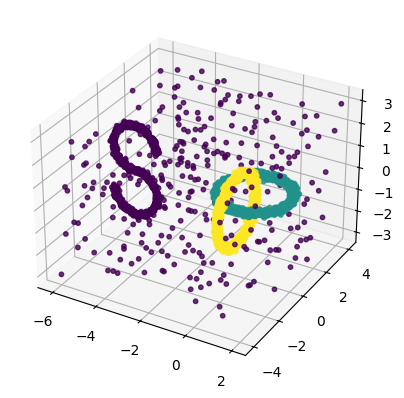

In [39]:
fig = plot_3d_data(X, l_, show_legend=False, show_plot=False)
axes = fig.get_axes()
for ax in axes:
    ax.set_aspect("equal", adjustable="datalim")

plt.show()